In [1]:
""" Resize the notbook to full width, to fit more code and images """
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
""" some basic packages and settings to show images inline """
import numpy as np
from easydict import EasyDict as edict
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2
""" Controls for figure sizes to change """
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams.update({'errorbar.capsize': 1})

from triplet import *

/tmp/ipykernel_1500/721591456.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


free GPUs: 0 1 2 3 4 5 6 7
using device: cuda:7


# Part 1. Retrieval

In [2]:
net = load_net('./models/net_class.pl') # load pretrained classification network

# qery test images, use all test set to retrive
torch.manual_seed(0)
loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=0)
queries, qlabels = next(iter(loader))
queries, qlabels = queries.to(dev), qlabels.to(dev)

### Display images with closest features to each query for classification-trained network

<Figure size 3200x800 with 0 Axes>

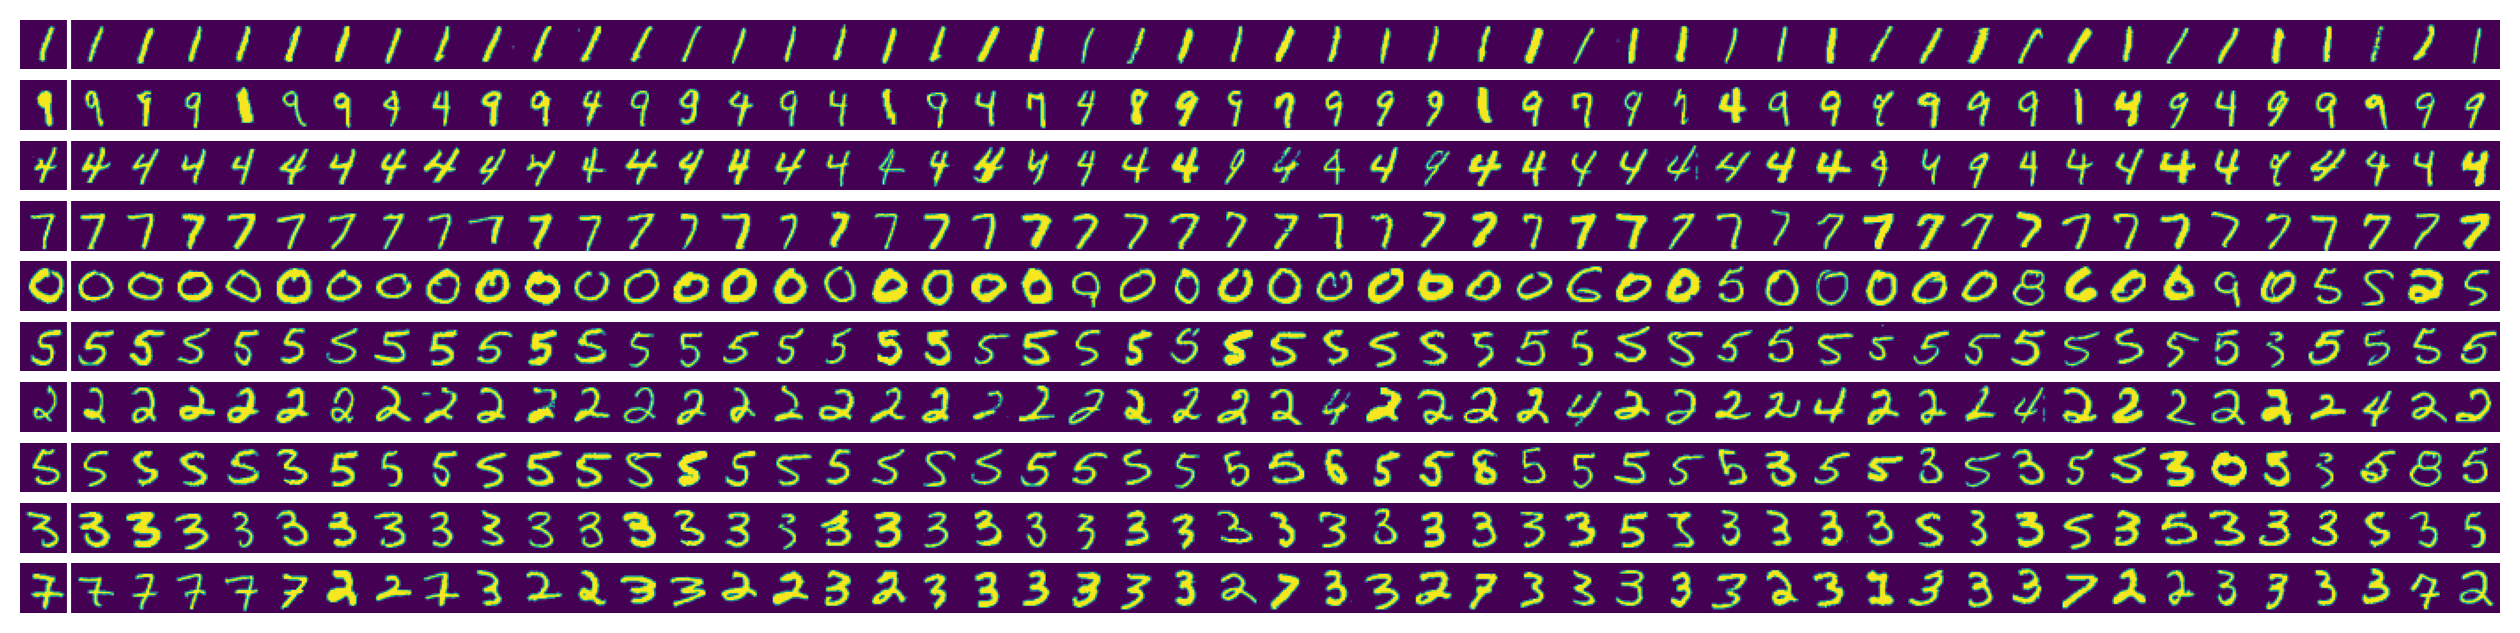

In [3]:
closest_images = get_closest_to_queries(net, queries, loader)
plot_closest_to_queries(closest_images)

### Show mAP and precision-recall curve for classification-trained network.

Since the feature vectors are normalized, squared Euclidian distance between two feature vectors are computed in a following way:

$d(x, y) = (x_1 - y_1)^2 + (x_n - y_n)^2 + ... + (x_n - y_n)^2 = x_1^2 - 2*x_1*y_1 + y_1^2 + x_2^2 - 2*x_2*y_2 + y_2^2 + ... + x_n^2 - 2*x_n*y_n + y_n^2 = (x_1^2  + x_2^2 + ... + x_n^2) + (y_1^2  + y_2^2 + ... + y_n^2) - 2* (x_1*y_1 + x_2*y_2 + ... + x_n*y_n) = 1 + 1 - 2*<x,y> = 2 - 2* <x,y>$

Dot products of all possible pairs in two sets of feature vectors `f2` and `f2` are computed with the help of `einsum` : `torch.einsum("nd,md->nm", f1, f2)`

............................................................X..XX.X.X....XX.XXXXX..X....XXX.X..XXX..
..........................X.X...X........X.X.......XXX.X.XXXXXXXXXXX..XXXXX.XX.X...X.XXXXXXXX.X.X.X.
....X.XXXXXXX.X.X.XXX.X.XXX.X..X.XXX.XXXXXXX.X..XXXX.XX.XX.XXXXXX.XXXXXX..XXXXXXXXX..X.XXXX..X.XXX.X
..........................X................X.......X...X...X..X..XX.XXXXXXXX.XXXXX..X.X.XX.XX.X.XXXX
.........................................X....................XXX.XX...XX.XXX.X.XX....XX.XX..XXX.XXX
....X.XX..X..XXX..X.XX.X..XXXXXXXXXXXXXXXX.XXXXXXX.XXXXXXXXXX.XXXXXXXXXXXXXXXXXXXXXXXXXXXX.X.XXXXXXX
.................................X........X.XX......X.......XXX.....XXX...X.XX..XXXXX.XXX.XXXXXX.XX.
.......................................X...X...X..XXXX.X....X...X..X.X...X.X.XX..XXXXX.XXX.XXXX.X.XX
........X.......X..X...XX.....X.X.XX.X.X.XXX.XX....XXXX...X.XXXXXX.XX.X..XX.XX..XXXXXX.XXX.XXX.XXXXX
..............................................................................X..X........X

Text(0.5, 1.0, 'precision-recall curve for classification-trained network')

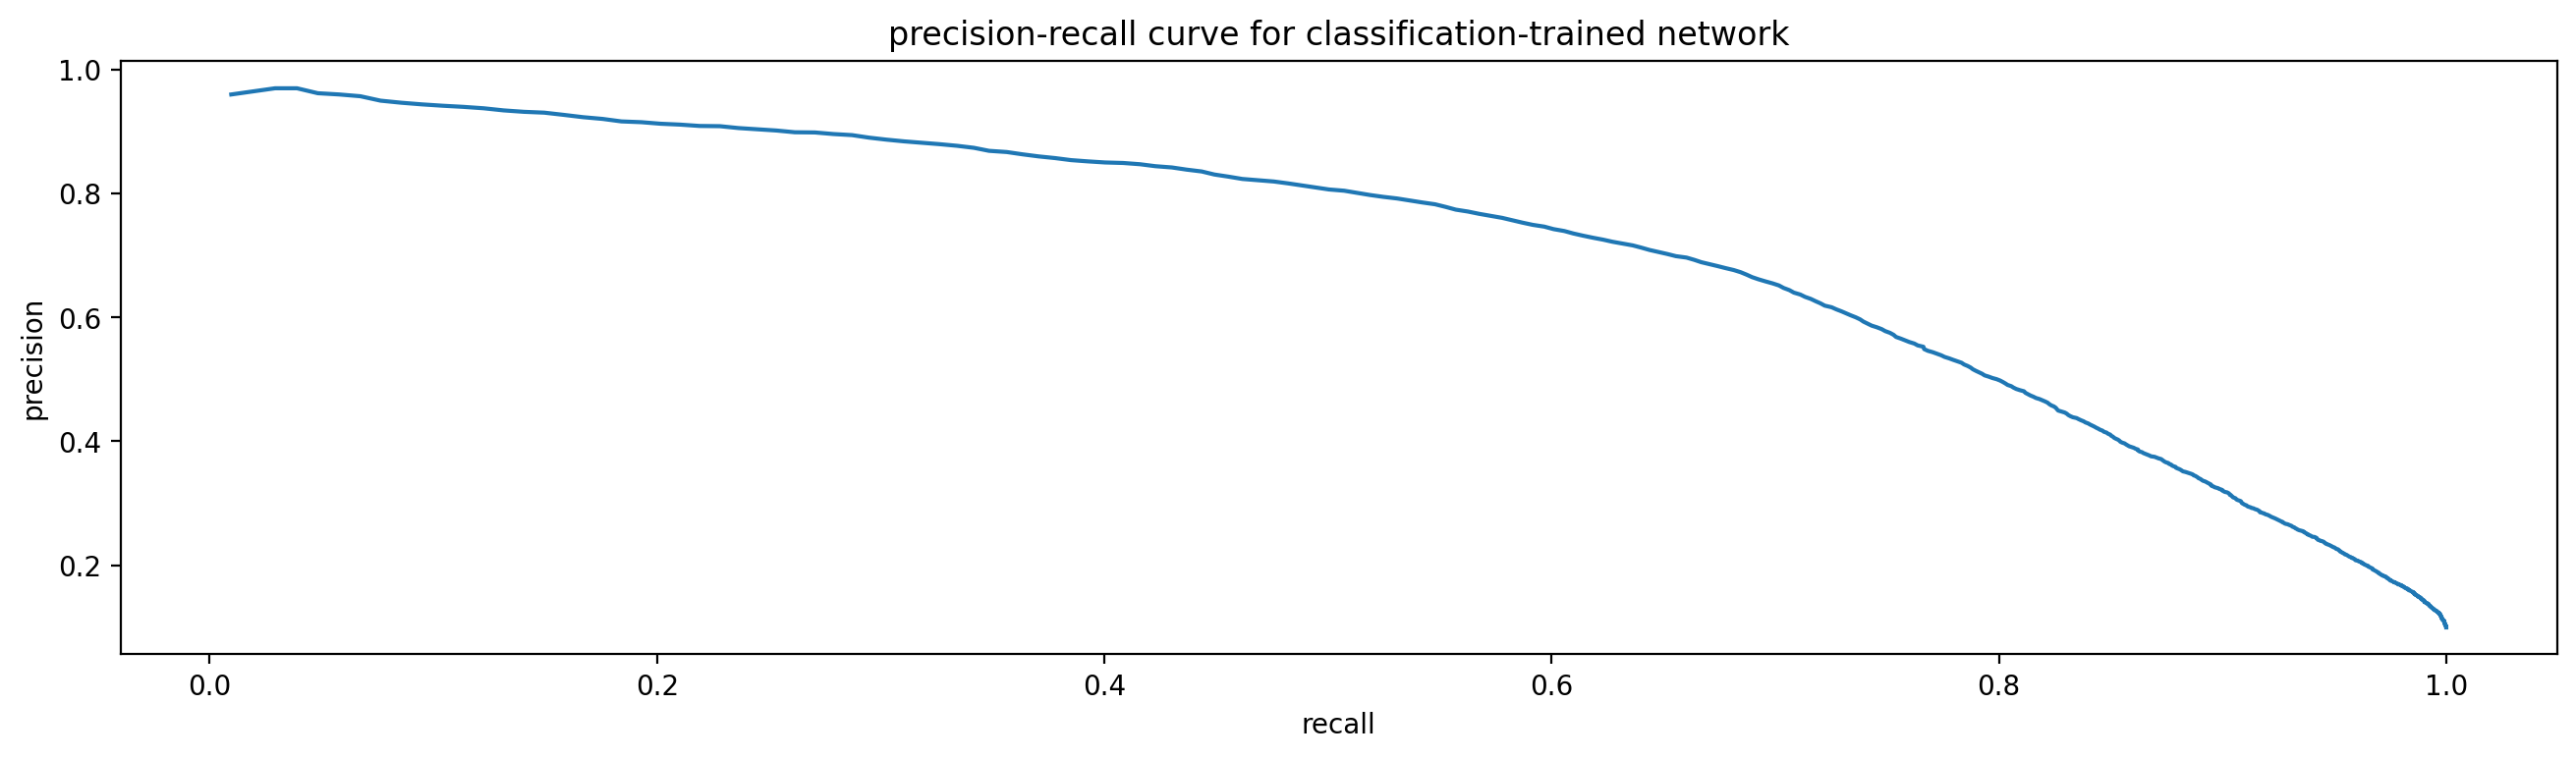

In [4]:
mAP, mPrec, mRec = evaluate_mAP(net, test_set)
print(f"{mAP = }")

""" Plot Precision vs. Recall"""
plt.plot(mRec, mPrec)
plt.xlabel("recall")
plt.ylabel("precision")

plt.title("precision-recall curve for classification-trained network")

# Part 2. Metric Learning

Load results of training the network with triplet loss.

In [5]:
do_training= False

if do_training:
    net_triplet = new_net()
    data_loader = edict({'train_loader': train_loader, 'val_loader':val_loader, 'test_loader': test_loader})
    results = train_triplets(net_triplet, data_loader, 100, "triplet loss")
else:
    from cnn_workflow.utils import load_pickle, load_state_to_network
    net_triplet = new_net()
    load_state_to_network(dev, './models/net_triplet.pl', net_triplet)
    results=load_pickle('models/net_triplet_training_history.pickle')

Show training and validation loss for each epoch during the training

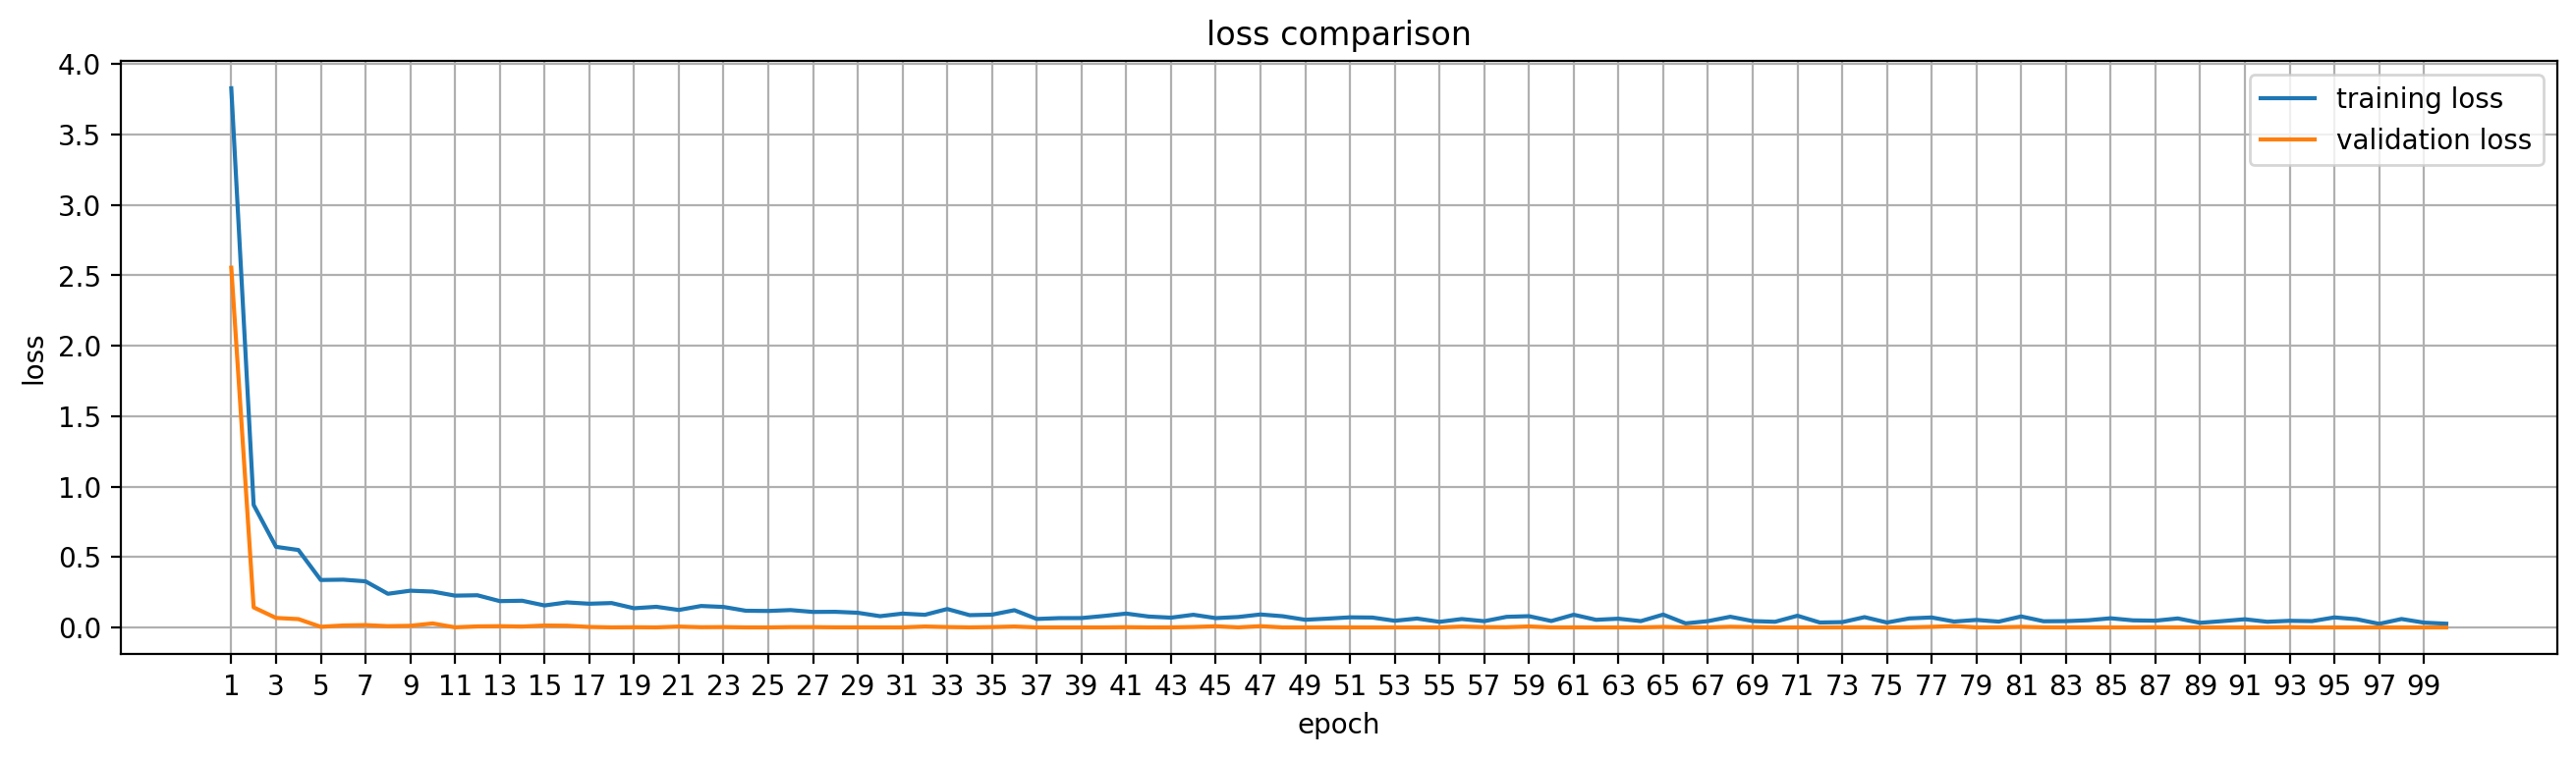

In [6]:
from cnn_workflow.utils import display_results_compare_one_loss
display_results_compare_one_loss(results)
_ = plt.xticks(list(range(1, 101, 2)))

### Show mAP for triplet-trained network

In [7]:
mAP, mPrec_triple, mRec_triple = evaluate_mAP(net_triplet, test_set)
print(f"{mAP = }")

.......................................................................................X...X..X.X.X.
..............................................................X............X.....XX...X...X..XXX.X.X
............................X.........................X.............X...XX..X.X.X.XX..X..XX...X.X.XX
.X......X....................................X..X....X.X..XX............XX.XX...X.XX..XX.X.XX.XX.XXX
..................................................................................................XX
................................X....X..........X.....X...XXX..X.X....XXX..X...X.X.XXX...X..XXXXXXXX
..........................................................................X........X...........XX.XX
.........................................................................................XX....XXXX.
......................................X...............X.....X.........X.........XX.X.X..XXXXXXX.XXXX
...........................................................................................

Compare precision-recall curves of classification-trained and triplet-trained networks

Text(0.5, 1.0, 'precision-recall comparison:')

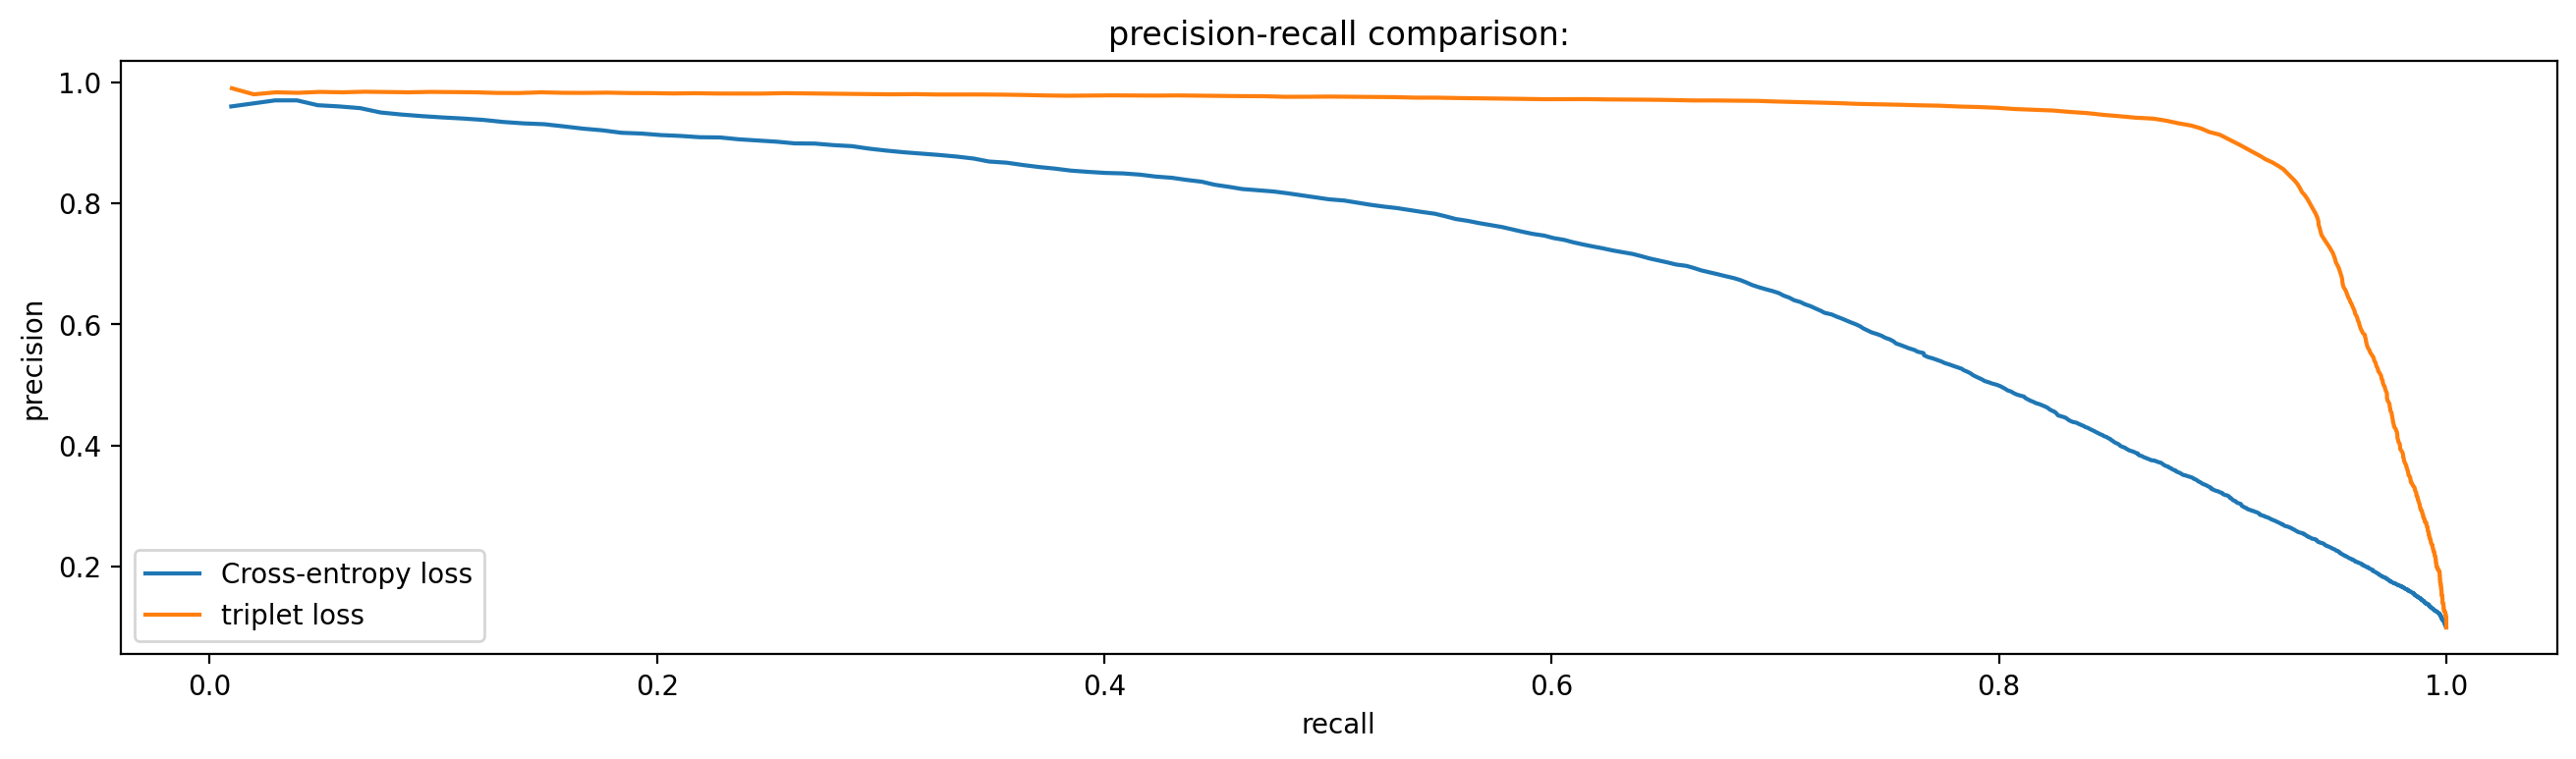

In [8]:
""" Plot Precision vs. Recall"""
plt.plot(mRec, mPrec)
plt.plot(mRec_triple, mPrec_triple)
plt.legend(['Cross-entropy loss', 'triplet loss'])
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision-recall comparison:")

### Display images with closest features to each query for triplet-trained network. More images match the query class, in comparison with the classification-trained network.

<Figure size 3200x800 with 0 Axes>

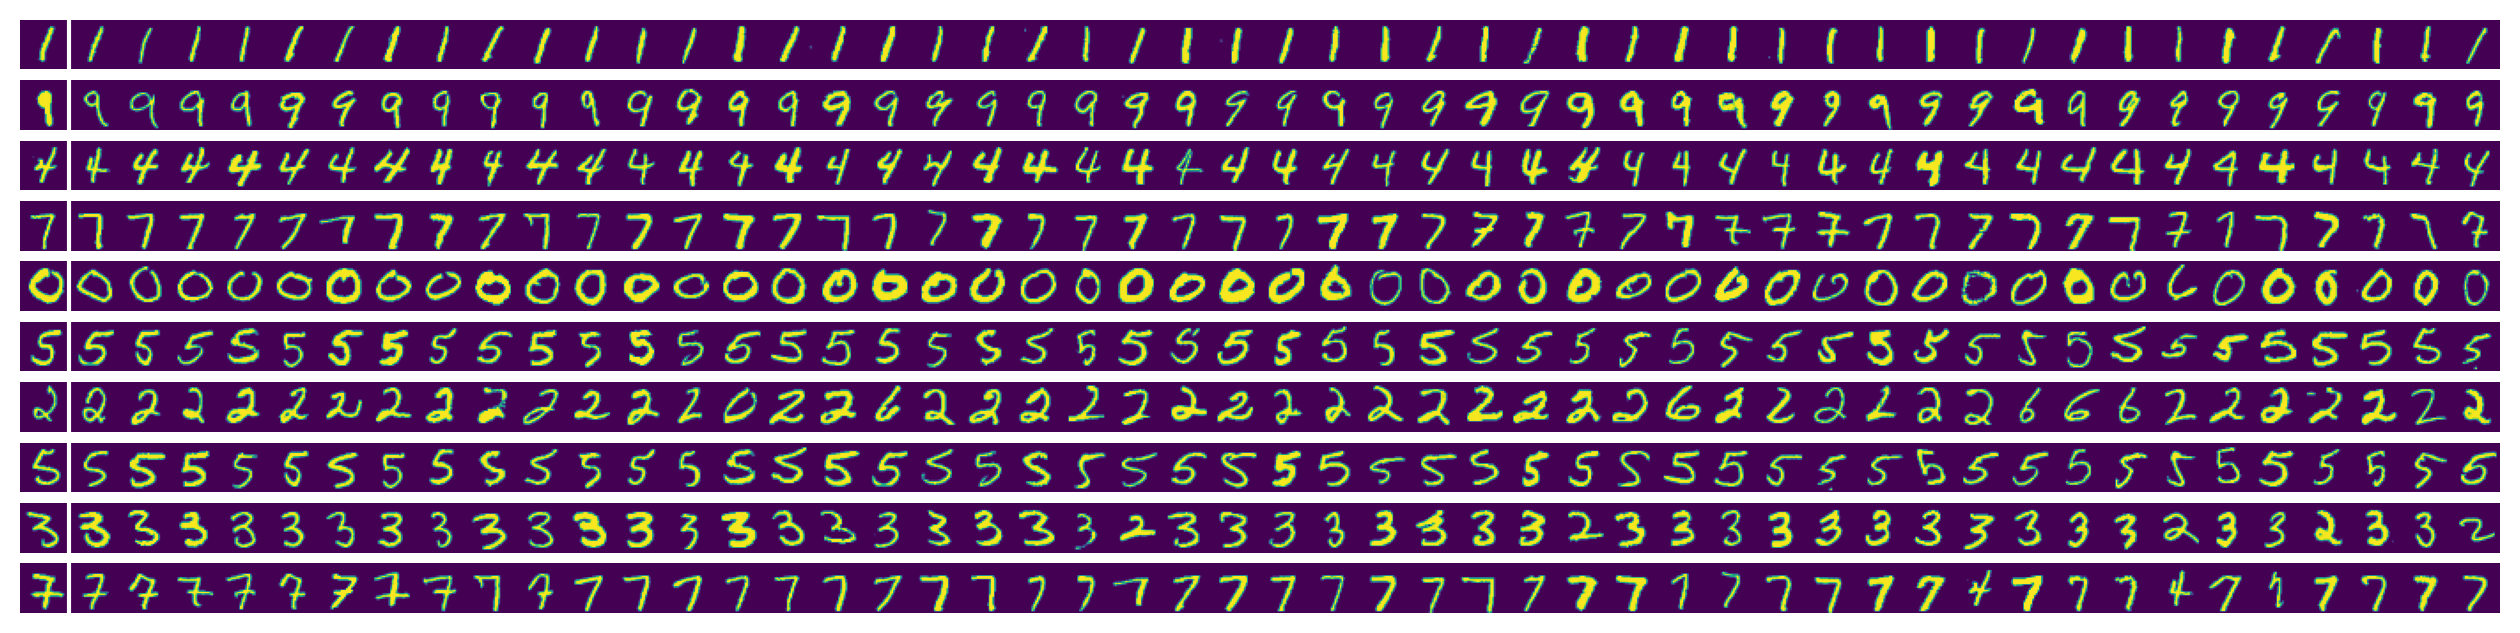

In [9]:
closest_images = get_closest_to_queries(net_triplet, queries, loader)
plot_closest_to_queries(closest_images)

Plot t-SNE embeddings of classification-trained and triplet-trained networks. For the triplet-trained network the embeddings are more closely grouped.

/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home.nfs/hladcvla/miniconda3/envs/dle_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


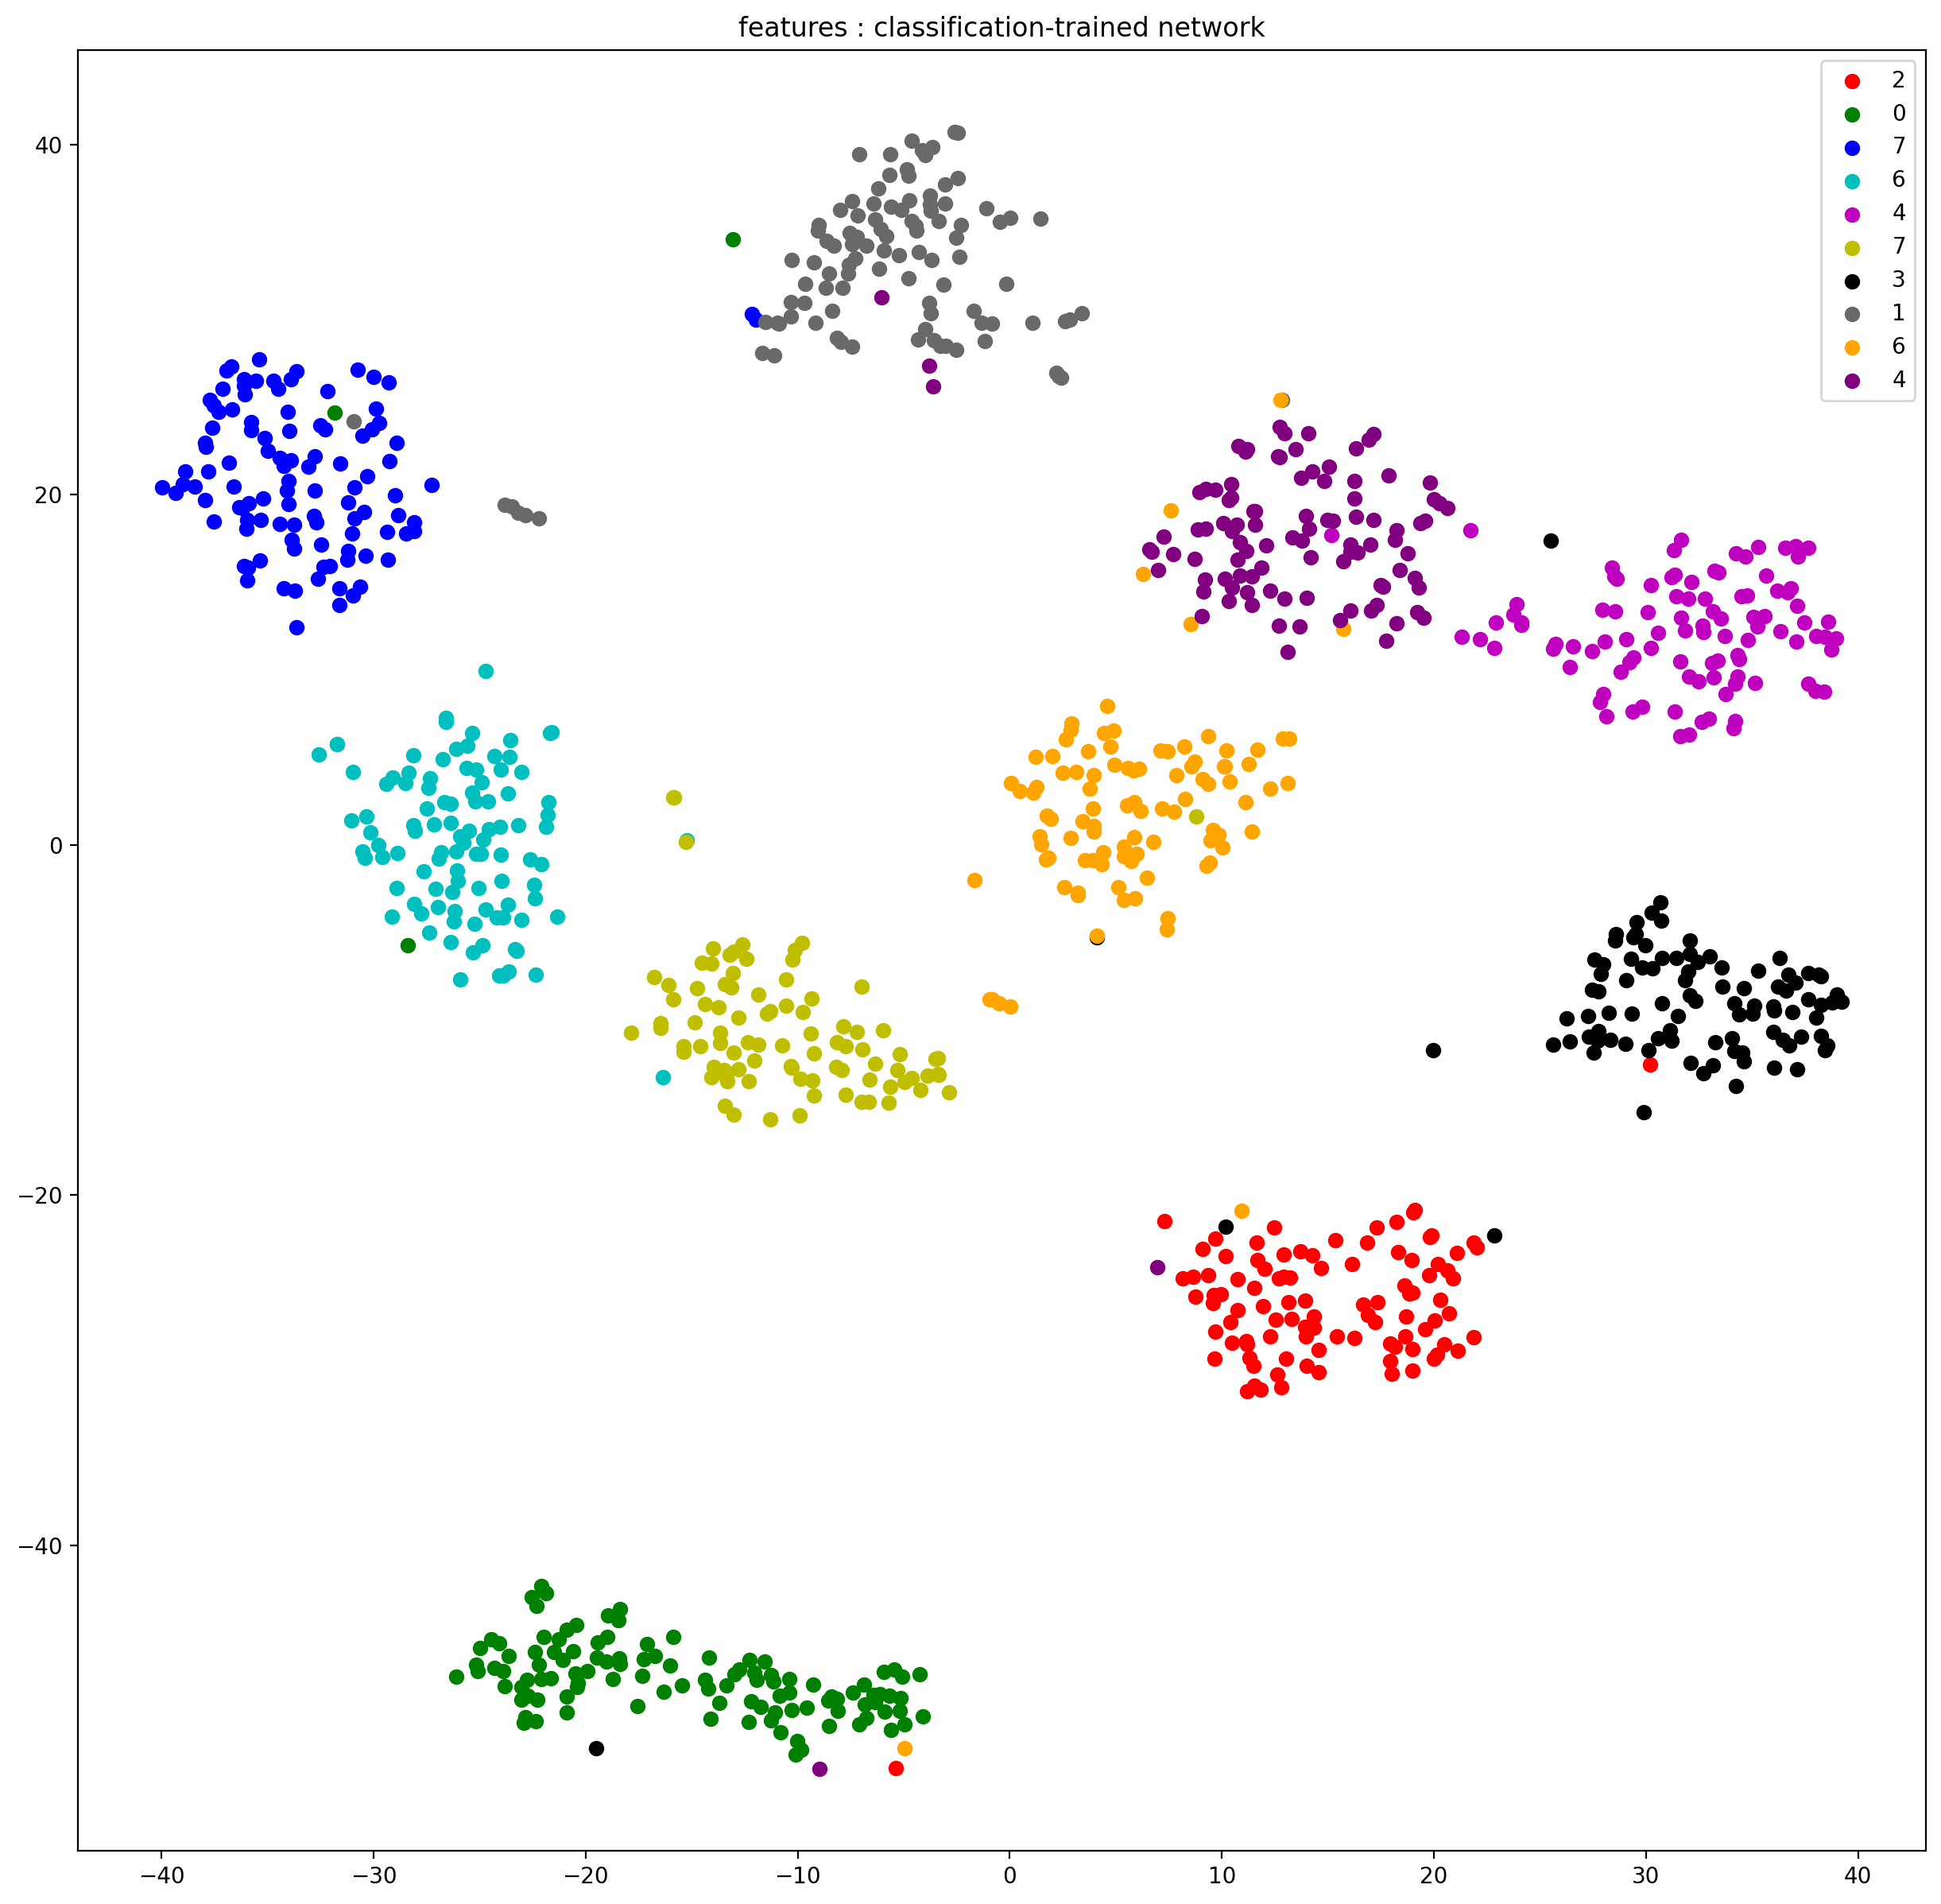

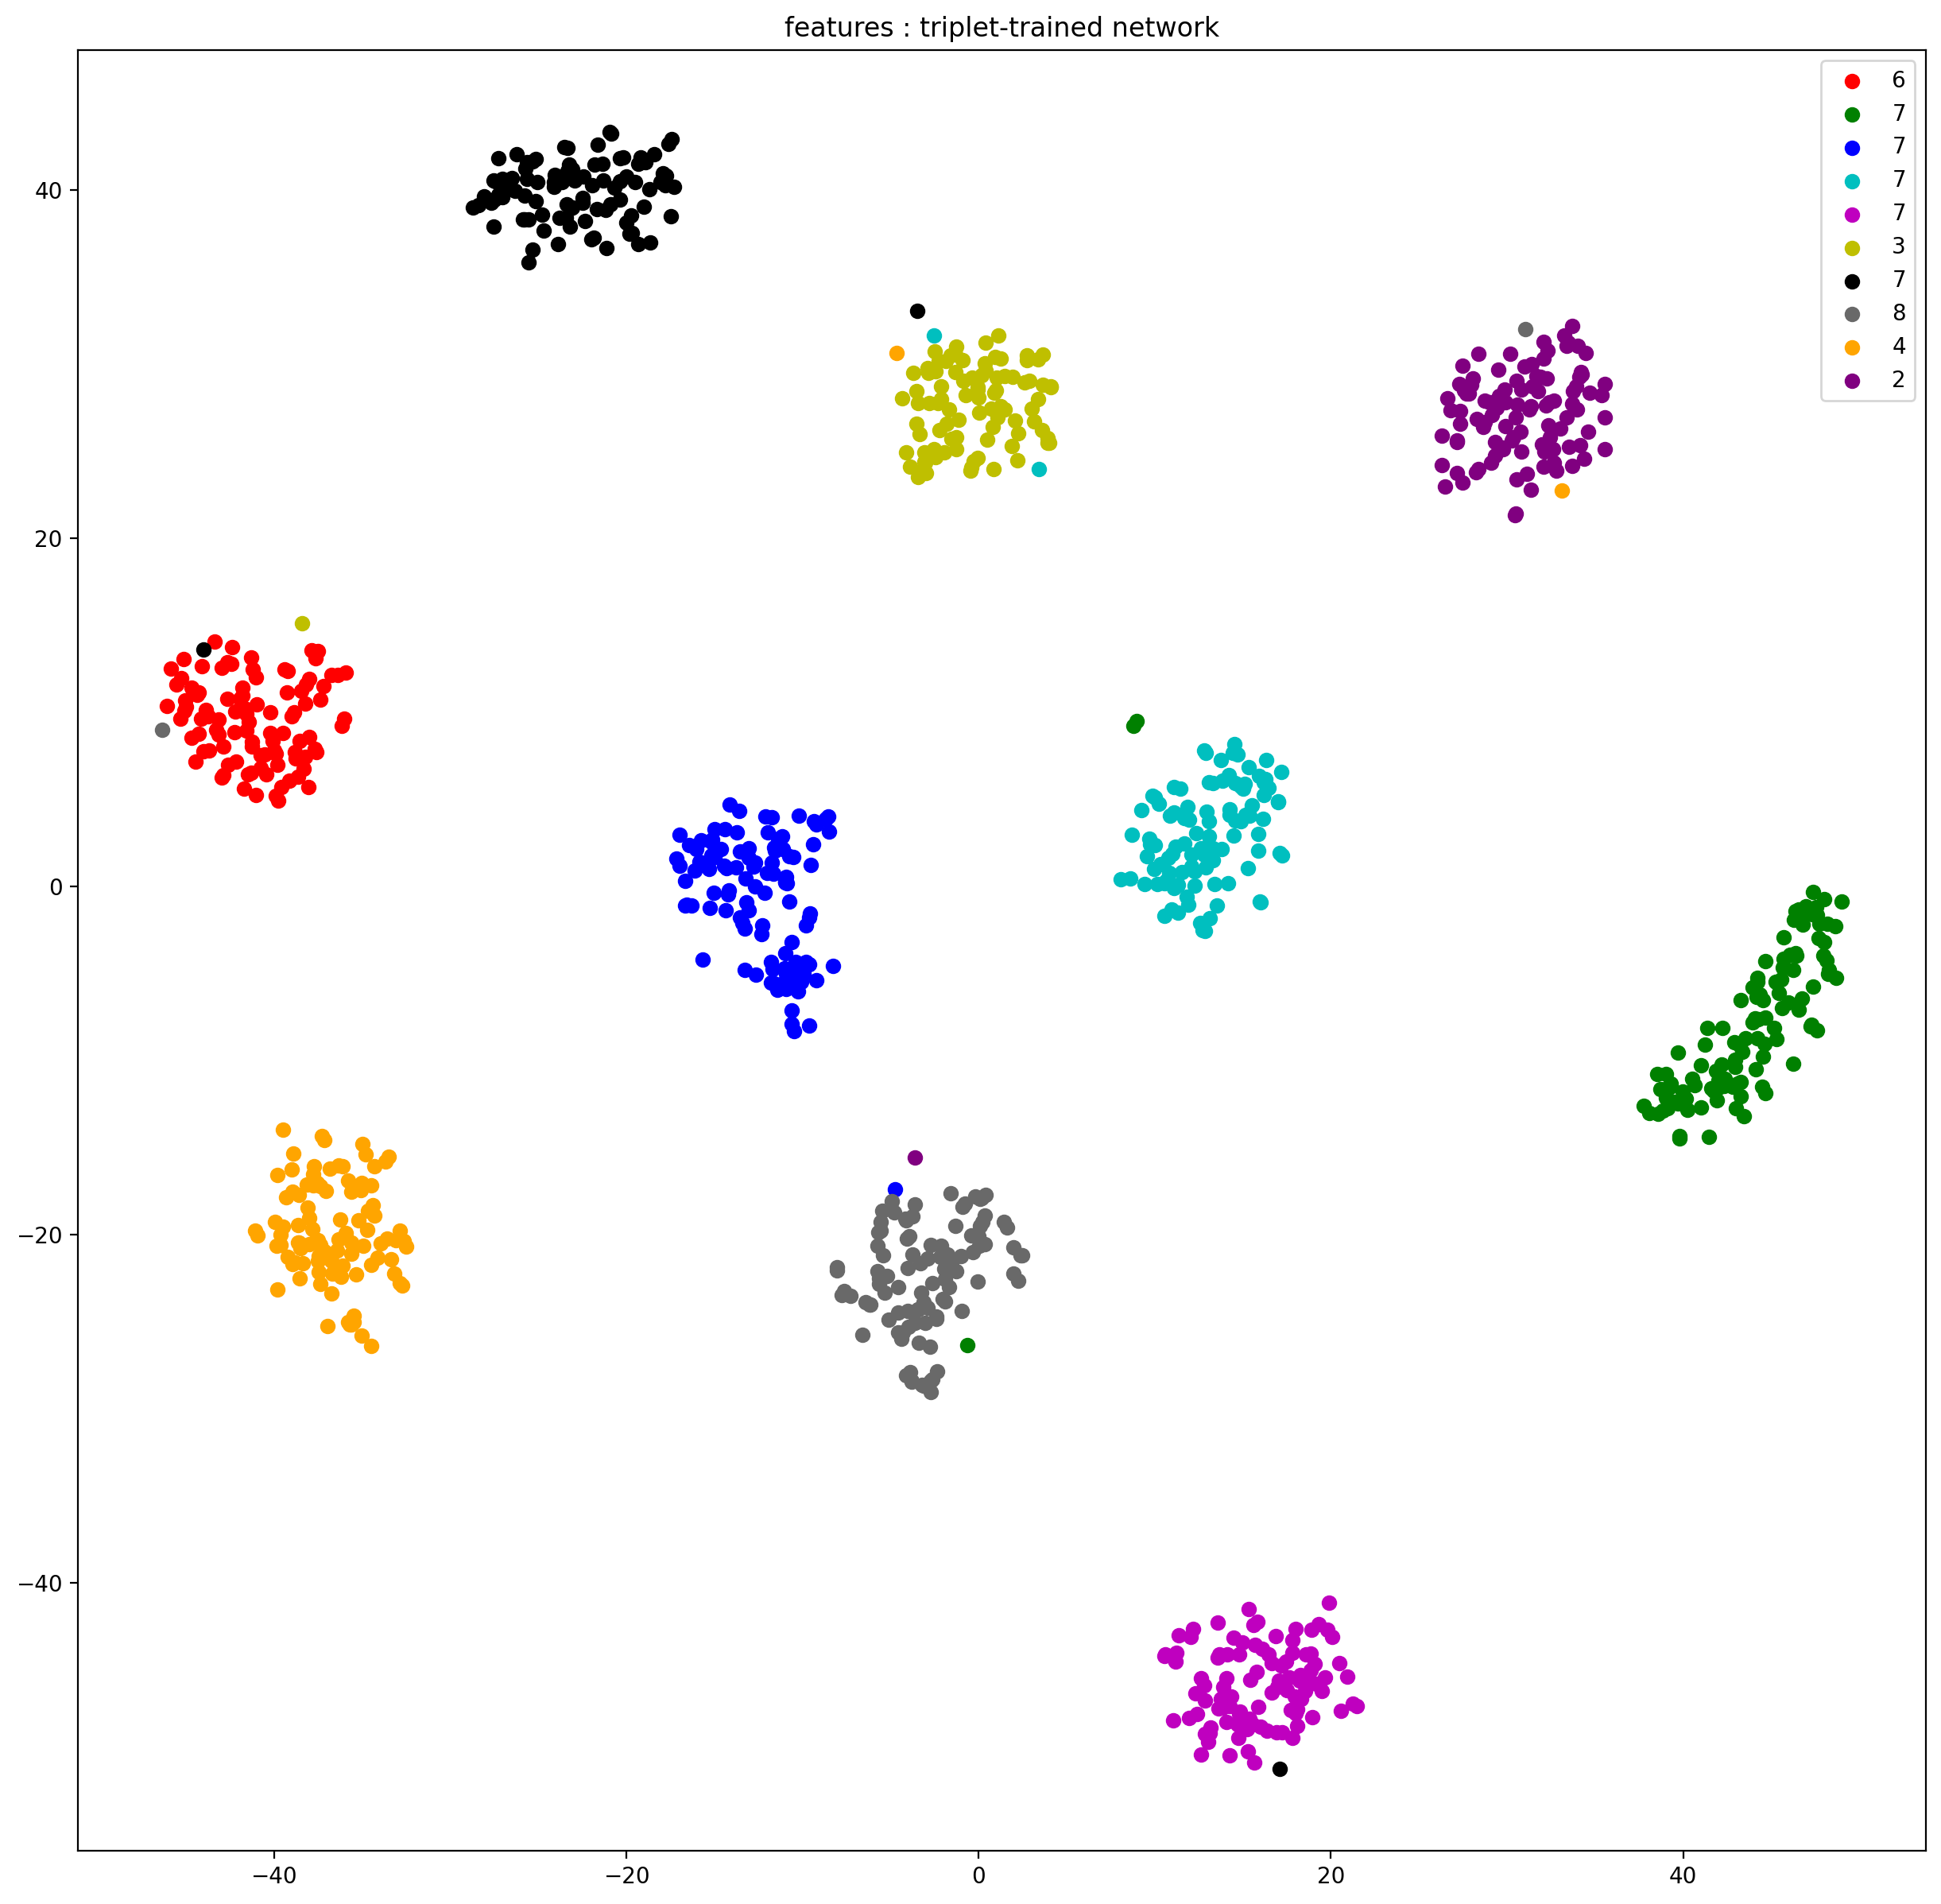

In [10]:
from cnn_workflow.utils import plot_tsne

features_class, labels_class = to_features(net, loader)
plot_tsne(features_class.cpu().detach().numpy(), labels_class.cpu().detach().numpy(), "classification-trained network")

features_triplet, labels_triplet = to_features(net_triplet, loader)
plot_tsne(features_triplet.cpu().detach().numpy(), labels_triplet.cpu().detach().numpy(), "triplet-trained network")